In [1]:
import keras 
import requests
import json
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

### Unrate

In [2]:
with open('api_key.json') as f:
    api_key = json.load(f)

In [3]:
URL = f'https://api.stlouisfed.org/fred/series/observations?series_id=UNRATE&api_key={api_key['api']}&file_type=json'

In [4]:
response = requests.get(URL)

In [5]:
data = pd.DataFrame(response.json()['observations'])

In [6]:
data['value'] = data['value'].astype(float)

Plotando serie

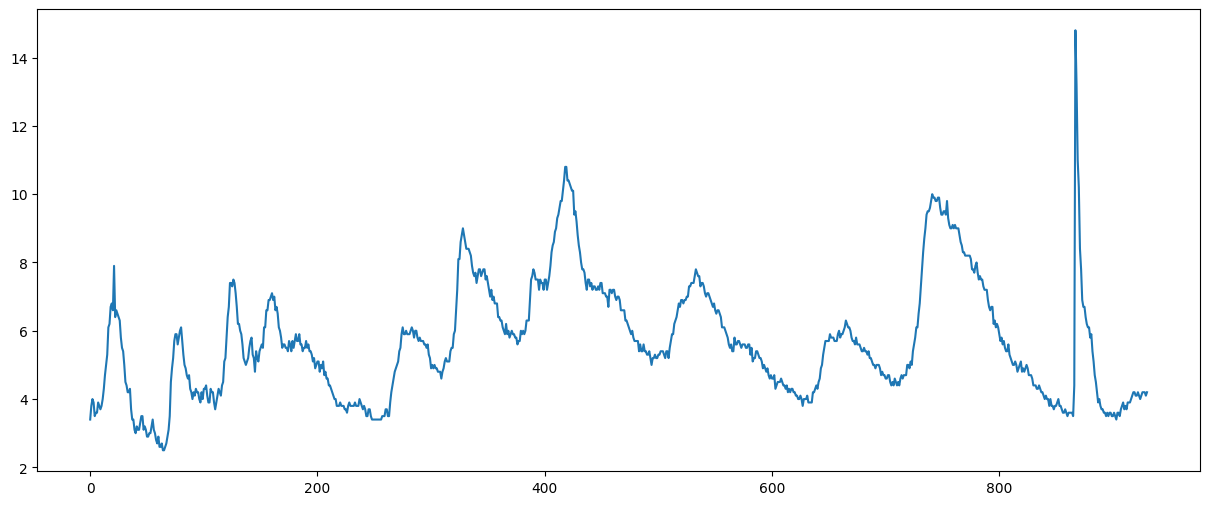

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(data['value'])

In [8]:
data['median_movel'] = data['value'].rolling(50).median()
data['variancia_movel'] = data['value'].rolling(50).var()

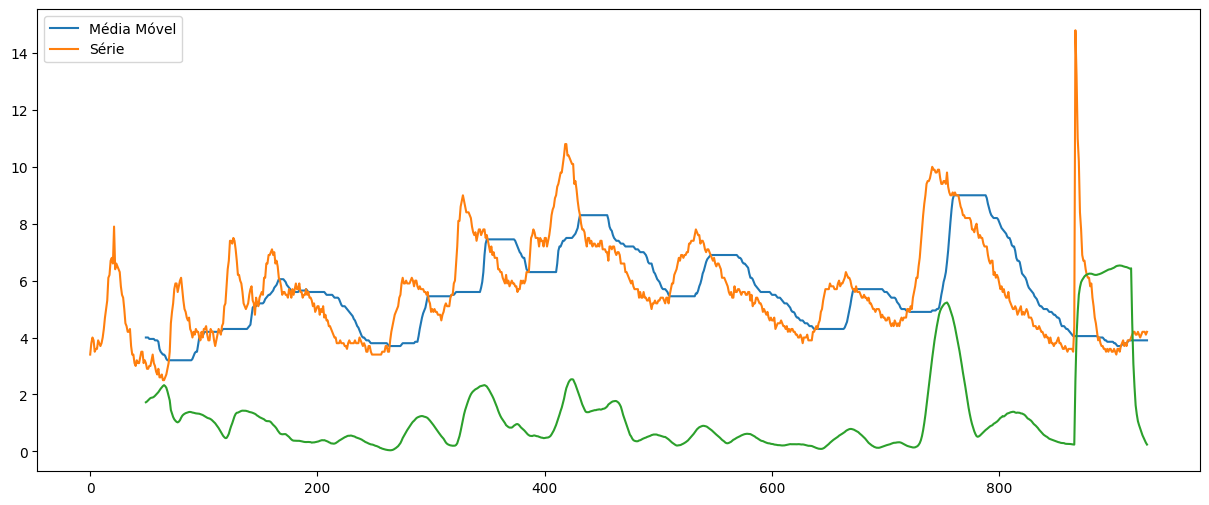

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(data['median_movel'], label='Média Móvel')
plt.plot(data['value'], label='Série')
plt.plot(data['variancia_movel'])
plt.legend()
plt.show()

Verificando estacionaridade

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

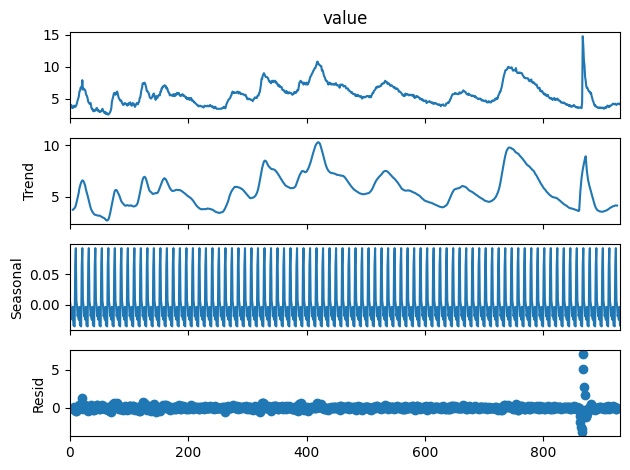

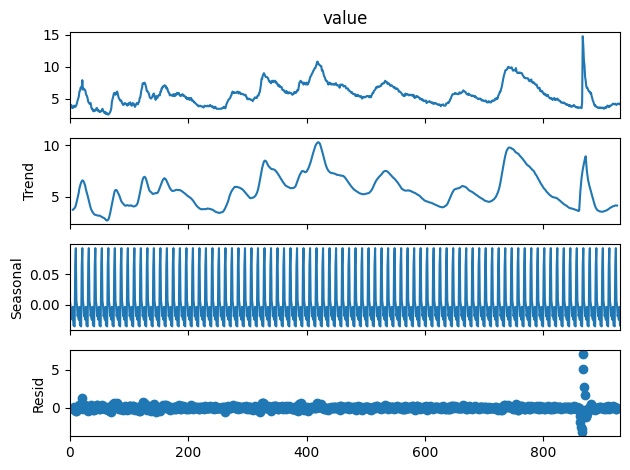

In [11]:
seasonal_decompose(data['value'], period=11, model='additive').plot()

In [12]:
# teste de estacionariedade kpss
from statsmodels.tsa.stattools import kpss
result = kpss(data['value'])


if result[1] < 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária")

A série não é estacionária


`Criando dados de treino e teste`

In [13]:
def gerador_dados(series, janela_tempo=50):
    X = []
    y = []
    for i in range(len(series) - janela_tempo):
        Xi = series[i:i + janela_tempo].reshape(-1, 1)
        yi =series[i + janela_tempo].reshape(-1, 1)
        X.append(Xi)
        y.append(yi)
    return np.array(X), np.array(y)

In [14]:
def range_plot(train_size, size_total, window):
    x = list(range(train_size))
    y = list(range(train_size-window, size_total))
    return x, y

In [15]:
X, y = gerador_dados(data['value'].values, janela_tempo=50)

In [16]:
xtrain, xtest, ytrain, ytest = (
    X[:int(len(X) * 0.8)],
    X[int(len(X) * 0.8)-50:],
    y[:int(len(y) * 0.8)],
    y[int(len(y) * 0.8)-50:],
)

`Criando modelo`

In [17]:
def model_ts_1():
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(50, return_sequences=True),
        keras.layers.SimpleRNN(50),
        keras.layers.Dense(1)
    ], name='Modelo1_TS')

    return model

model = model_ts_1()

In [18]:
model.compile(
    loss      = keras.losses.mean_squared_error,
    optimizer = keras.optimizers.Adam(),
    metrics   = [keras.metrics.mean_squared_error]
)
history = model.fit(
    xtrain, ytrain, epochs=10
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - loss: 12.9375 - mean_squared_error: 12.9375
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 1.5783 - mean_squared_error: 1.5783
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.6207 - mean_squared_error: 0.6207
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - loss: 0.3165 - mean_squared_error: 0.3165
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - loss: 0.1998 - mean_squared_error: 0.1998
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 0.2448 - mean_squared_error: 0.2448
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1768 - mean_squared_error: 0.1768
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.1048 - mean_squared_error: 0.1048
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1209 - mean_squared_error: 0.1209
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0906 - mean_squared_error: 0.0906


In [19]:
pred = model.predict(xtest)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step


In [20]:
train, test = range_plot(len(xtrain), len(X), 50)

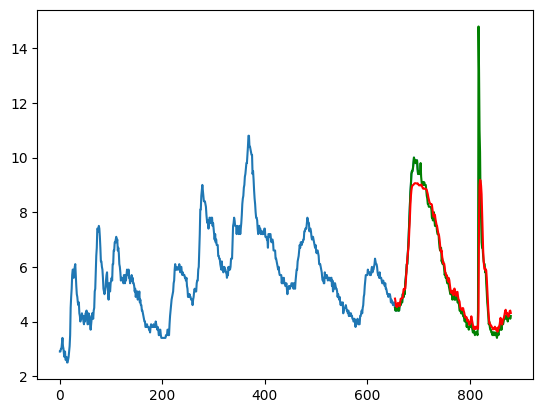

In [21]:
plt.plot(ytrain.reshape(-1, 1))
plt.plot(test, ytest.reshape(-1, 1), color='green')
plt.plot(test, pred, color='red')

In [22]:
ultimo = xtest[-1]

pred_futuro = []
for i in range(100):
    pred = model.predict(ultimo.reshape(1, 50, 1))

    pred_futuro.append(pred[0, 0])
    
    ultimo = np.append(ultimo[1:], pred_futuro[-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [34]:
pred_train = model.predict(xtrain, verbose=0)

pred_test = model.predict(xtest, verbose=0)

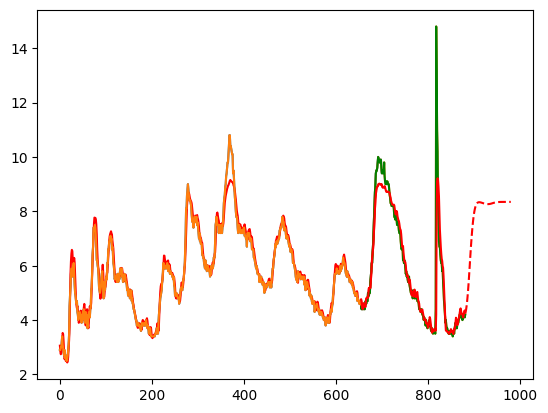

In [38]:
plt.plot(ytrain.reshape(-1, 1))
plt.plot(pred_train, color='red')
plt.plot(data['value'].values[50:])
plt.plot(test, ytest.reshape(-1, 1), color='green')
plt.plot(test, pred_test, color='red')
plt.plot(range(test[-1], test[-1]+ 100), pred_futuro, '--',color='red')

`modelo 2 GRU`

In [25]:
def model_ts_1():
    model = keras.models.Sequential([
        keras.layers.GRU(50, return_sequences=True),
        keras.layers.GRU(50),
        keras.layers.Dense(1)
    ], name='Modelo1_TS')

    return model

model = model_ts_1()

In [26]:
model = model_ts_1()

In [27]:
model.compile(
    loss      = keras.losses.mean_squared_error,
    optimizer = keras.optimizers.Adam(),
    metrics   = [keras.metrics.mean_squared_error]
)
history = model.fit(
    xtrain, ytrain, epochs=10
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 17.1701 - mean_squared_error: 17.1701
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 1.9209 - mean_squared_error: 1.9209
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 1.6085 - mean_squared_error: 1.6085
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 1.0193 - mean_squared_error: 1.0193
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.8082 - mean_squared_error: 0.8082
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.4764 - mean_squared_error: 0.4764
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.2400 - mean_squared_error: 0.2400
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.1847 - mean_squared_error: 0.1847
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.1624 - mean_squared_error: 0.1624
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0951 - mean_squared_error: 0.0951


In [30]:
pred_test = model.predict(xtest)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [28]:
ultimo = xtest[-1]

pred_futuro = []
for i in range(100):
    pred = model.predict(ultimo.reshape(1, 50, 1), verbose=0)

    pred_futuro.append(pred[0, 0])
    
    ultimo = np.append(ultimo[1:], pred_futuro[-1])

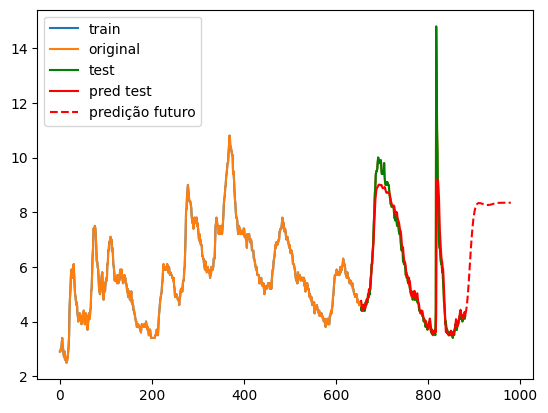

In [33]:
plt.plot(ytrain.reshape(-1, 1), label='train')
plt.plot(data['value'].values[50:], label='original')
plt.plot(test, ytest.reshape(-1, 1), color='green', label='test')
plt.plot(test, pred_test,color='red', label='pred test' )
plt.plot(range(test[-1], test[-1]+ 100), pred_futuro, '--',color='red', label='predição futuro')
plt.legend()
plt.show()

`LTSM`

In [39]:
def model_ts_1():
    model = keras.models.Sequential([
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.LSTM(50),
        keras.layers.Dense(1)
    ], name='Modelo1_TS')

    return model

model = model_ts_1()

In [40]:
model.compile(
    loss      = keras.losses.mean_squared_error,
    optimizer = keras.optimizers.Adam(),
    metrics   = [keras.metrics.mean_squared_error]
)
history = model.fit(
    xtrain, ytrain, epochs=10
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 24.2642 - mean_squared_error: 24.2642
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.7627 - mean_squared_error: 2.7627
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.2692 - mean_squared_error: 2.2692
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.2724 - mean_squared_error: 2.2724
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.5003 - mean_squared_error: 2.5003
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.4339 - mean_squared_error: 1.4339
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.7031 - mean_squared_error: 0.7031
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.3475 - mean_squared_error: 0.3475
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.2932 - mean_squared_error: 0.2932
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.2164 - mean_squared_error: 0.2164


In [41]:
pred_test = model.predict(xtest, verbose=0)
pred_train = model.predict(xtrain, verbose=0)

In [42]:
ultimo = xtest[-1]

pred_futuro = []
for i in range(100):
    pred = model.predict(ultimo.reshape(1, 50, 1), verbose=0)

    pred_futuro.append(pred[0, 0])
    
    ultimo = np.append(ultimo[1:], pred_futuro[-1])

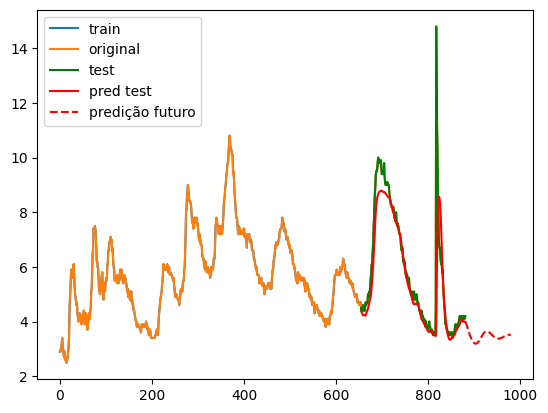

In [43]:
plt.plot(ytrain.reshape(-1, 1), label='train')
plt.plot(data['value'].values[50:], label='original')
plt.plot(test, ytest.reshape(-1, 1), color='green', label='test')
plt.plot(test, pred_test,color='red', label='pred test' )
plt.plot(range(test[-1], test[-1]+ 100), pred_futuro, '--',color='red', label='predição futuro')
plt.legend()
plt.show()

`arima`

In [49]:
# exponencial smoothing

from statsmodels.tsa.api import ExponentialSmoothing

In [56]:
exp = ExponentialSmoothing(data['value'].values)
result = exp.fit()

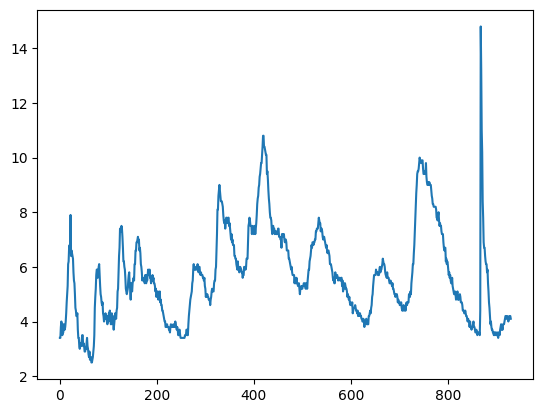

In [57]:
plt.plot(result.fittedvalues)